# GNN4Chem
Notebook contains Jennie's documentation of GNN models and performance

**To use**: Run the following code block for imports + hyperparameters + data loaders then run each model individually

**Note**: Jennie has her own implementation of train.py and test.py to speed things up on CUDA. To use them, comment out the train.py and test.py imports in the block below, and run the code blocks under the header 'py files'.

In [1]:
## imports
import torchaudio
from torch_geometric.loader import DataLoader
from torch_geometric import datasets
import torch
import torch.nn as nn
from torch_geometric.nn import MFConv, TransformerConv, ClusterGCNConv

from train import train
from test import test

## data
num_epochs = 1000
lr = 1e-3
debug=False

train_dataset = datasets.PPI(root="./data", split="train")
train_dataset.shuffle()
val_dataset = datasets.PPI(root="./data", split="val")
test_dataset = datasets.PPI(root="./data", split="test")
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)
in_channels = train_dataset.num_features
out_channels = train_dataset.num_classes

C:\Users\lenni\miniconda3\envs\gnn4chem\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


# py files

**Note**: Jennie has her own implementation of train.py and test.py to speed things up on CUDA. To use them, comment out the train.py and test.py imports in the block below, and run the following code blocks.

In [24]:
import time
import torch
import matplotlib.pyplot as plt
import metrics
import torchaudio
from torchmetrics import F1Score

def train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=False):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    my_device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(my_device)
    f1 = F1Score(task="multilabel", num_labels = out_channels).to(my_device)
    
    # training performance storage
    losses, f_score, val_losses, val_f_score = [], [], [], []
    t0, time_elapsed = time.time(), []
    
    for epoch in range(num_epochs):
        # training performance tracking per epoch
        total_loss, batch_count, f_total = 0, 0, 0
        val_total_loss, val_batch_count, val_f_total = 0, 0, 0

        # training
        for batch in train_loader:
            optimizer.zero_grad()
            pred = model(batch.to(my_device))
            loss = loss_fn(pred, batch.y.to(my_device))
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            batch_count += 1
            f_total += f1(pred, batch.y)
         
        mean_loss = total_loss / batch_count
        mean_f1 = f_total / batch_count
        losses.append(mean_loss)
        f_score.append(mean_f1)
        
        if debug:
            print(f"train loss at epoch {epoch} = {mean_loss}")
            print(f"train mean f1 score at epoch {epoch} = {mean_f1}")
            
        # validation
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(my_device)
                output = model(batch.to(my_device))
                loss = loss_fn(output, batch.y.to(my_device))
                val_total_loss += loss.item()
                val_batch_count += 1
                val_f_total += f1(output,batch.y)
    
        val_mean_loss = val_total_loss / val_batch_count
        val_mean_f1 = val_f_total / val_batch_count
        val_losses.append(val_mean_loss)
        val_f_score.append(val_mean_f1)
        time_elapsed.append(time.time()-t0)
        
        if debug:
            print(f"validation loss at epoch {epoch} = {val_mean_loss}")
            print(f"validation mean f1 score at epoch {epoch} = {val_mean_f1}")

    print(f"train loss at epoch {epoch} = {mean_loss}")
    print(f"train mean f1 score at epoch {epoch} = {mean_f1}")
    print(f"validation loss at epoch {epoch} = {val_mean_loss}")
    print(f"validation mean f1 score at epoch {epoch} = {val_mean_f1}")
    
    plt.plot(losses, label='train')
    plt.plot(val_losses, label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('mean loss')
    plt.grid()
    plt.savefig('GCN_mean_loss.png')
    torch.save(model.state_dict(), f"model_state/GCN_WW_lr_{lr}_epoch_{num_epochs}.pth")

    return model

In [25]:
def test(model, test_loader, in_channels, out_channels, num_epochs, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = GCNConvNet(in_channels=in_channels, out_channels=out_channels)
    model.load_state_dict(torch.load(f"model_state/GCN_WW_lr_{lr}_epoch_{num_epochs}.pth")) #path to load the model
    model.to(device)
    model.eval()
    predictions = torch.Tensor().to(device)
    labels = torch.Tensor().to(device)
    
    with torch.no_grad():
        for batch in test_loader:
          batch = batch.to(device)
          output = model(batch.to(device))
          predictions = torch.cat((predictions, output.to(device)), 0)
          labels = torch.cat((labels, batch.y.to(device)), 0)

    f1score = F1Score(task="multilabel", num_labels = out_channels).to(device)
    msescore = MeanSquaredError().to(device)
    accuracy = Accuracy(task="multilabel", num_labels = out_channels).to(device)
    precision = Precision(task="multilabel", num_labels = out_channels).to(device)
    specificity = Specificity(task="multilabel", num_labels = out_channels).to(device)
    sensitivity = Recall(task="multilabel", num_labels = out_channels).to(device)
    #matthews_corrcoef = MatthewsCorrCoef(task="multilabel", num_labels = out_channels).to(device)
    auroc = AUROC(task="multilabel", num_labels = out_channels).to(device)
    auprc = AveragePrecision(task="multilabel", num_labels = out_channels).to(device)
    
    auroc2 = metrics.auroc(labels.cpu().numpy().flatten(), predictions.cpu().numpy().flatten())
    auprc2 = metrics.auprc(labels.cpu().numpy().flatten(), predictions.cpu().numpy().flatten())
    
    print(f'MSE loss : {msescore(predictions, labels)}')
    print(f'Accuracy : {accuracy(predictions, labels)}')
    print(f'precision: {precision(predictions, labels)}')
    print(f'Sensititvity :{sensitivity(predictions, labels)}')
    print(f'specificity : {specificity(predictions, labels)}')
    print(f'f-score : {f1score(predictions, labels)}')
    #print(f'MCC : {matthews_corrcoef(predictions, labels)}')
    print(f'AUROC: {auroc(predictions, labels.int())}')
    print(f'AUROC (metrics): {auroc2}')
    print(f'AUPRC: {auprc(predictions, labels.int())}')
    print(f'AUPRC (metrics): {auprc2}')

# Run Models

Jennie's documentation of the following GNN models.
- MFConv: JB_MF, JB_MFTrans (MFConv + Transformer), JB_MFConv2 (MFConv with added extra conv layer), **JB_MFGIN (MFConv+GIN - Best F1)**
- ClusterConv: JB_Cluster, JB_ClusterMF (includes MFConv layer), WW_ClusterGCN (weichens model)
- GIN: WW_GIN (weichens model)
- GCNII (not yet working)
- SAGE: JB_SAGE
- GAT: JB_GAT, IR_GAT (rakas model)

Model performance - trained @ 8000 epochs
| Model | Train F1 | Val F1 | Test F1 |
| --- | --- | --- | --- |
| JB_MF | 0.951 | .907 | .924 |
| JB_MFTrans | 0.958 | .909 | .929 |
| JB_MF2 | .967 | .939 | .950 |
| JB_MFGIN | .967 | .942 | .952 |
| WW_GIN | .962 | .932 | .946 |
| ? | 0.913 | .845 | .865 |
| JB_Cluster | .897 | .865 | .878 |
| JB_ClusterMF | .940 | .906 | .920 |
| WW_Cluster | .769 | .732 | .750 |
| IR_Gat | .769 | .741 | .761 |
| YL_Sage | .864 | .807 | .827 |83737183
1025238
40859985

## MFConv

### JB_MF

In [ ]:
from torch_geometric.nn import SSGConv, MFConv, TransformerConv

train loss at epoch 999 = 164.54090372721353
train mean f1 score at epoch 999 = 0.9133280515670776
validation loss at epoch 999 = 157.65078735351562
validation mean f1 score at epoch 999 = 0.8451273441314697
MSE loss : 0.08026866614818573
Accuracy : 0.9167479276657104
precision: 0.8429975509643555
Sensititvity :0.8871241807937622
specificity : 0.9294054508209229
f-score : 0.8644981384277344
MCC : 0.8050162196159363
AUROC: 0.8974747657775879
AUROC (metrics): 0.930930774841416
AUPRC: 0.8148082494735718
AUPRC (metrics): 0.8417831502373502


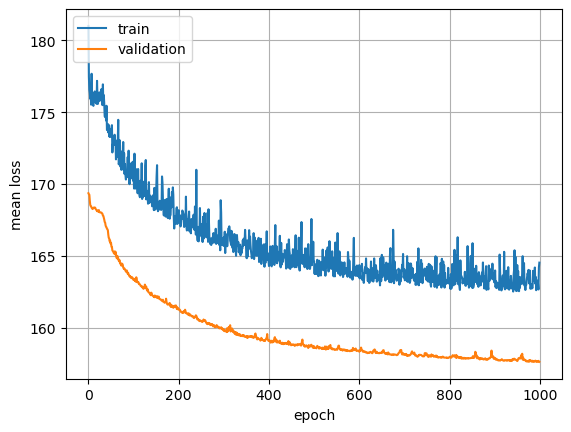

In [4]:
from models import JB_MF
model = JB_MF.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### MF @8000 epoch

train loss at epoch 7999 = 162.98189798990884
train mean f1 score at epoch 7999 = 0.9513589143753052
validation loss at epoch 7999 = 155.93036651611328
validation mean f1 score at epoch 7999 = 0.9073693752288818
MSE loss : 0.04584095999598503
Accuracy : 0.9536178708076477
precision: 0.9114249348640442
Sensititvity :0.9360306859016418
specificity : 0.9611324071884155
f-score : 0.9235639572143555
MCC : 0.8904430866241455
AUROC: 0.9369909167289734
AUROC (metrics): 0.9583780746862917
AUPRC: 0.8846640586853027
AUPRC (metrics): 0.8970167168358453


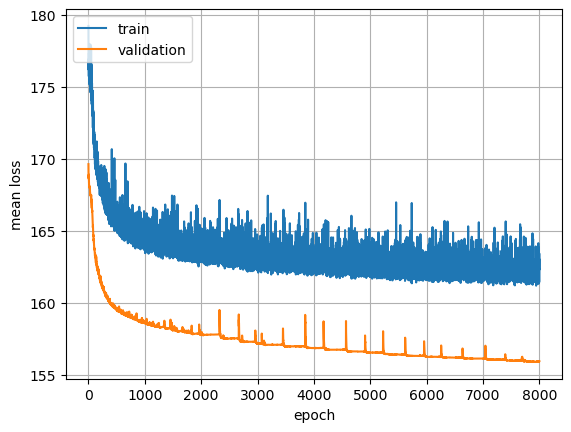

In [8]:
num_epochs=8000
from models import JB_MF
model = JB_MF.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### JB_MFTrans

train loss at epoch 999 = 164.33556111653647
train mean f1 score at epoch 999 = 0.890279233455658
validation loss at epoch 999 = 158.07520294189453
validation mean f1 score at epoch 999 = 0.825145959854126
MSE loss : 0.09163251519203186
Accuracy : 0.9048599600791931
precision: 0.8143949508666992
Sensititvity :0.8835608959197998
specificity : 0.9139604568481445
f-score : 0.8475691676139832
MCC : 0.7799522280693054
AUROC: 0.8821603655815125
AUROC (metrics): 0.9212148688725161
AUPRC: 0.7892007827758789
AUPRC (metrics): 0.8112299873003508


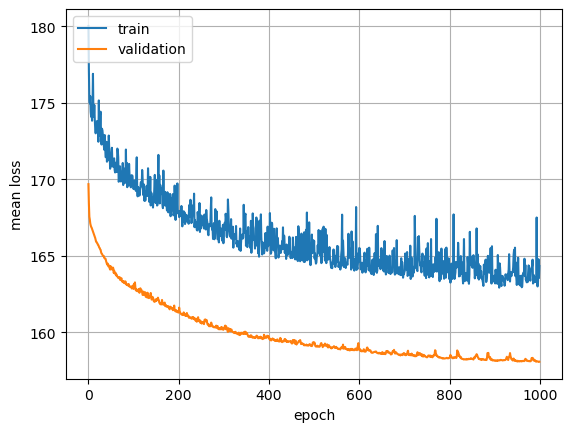

In [4]:
from models import JB_MFTrans
model = JB_MFTrans.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### MFTrans @8000 epoch

train loss at epoch 7999 = 162.4917755126953
train mean f1 score at epoch 7999 = 0.9581775665283203
validation loss at epoch 7999 = 155.93336486816406
validation mean f1 score at epoch 7999 = 0.9090740084648132
MSE loss : 0.042275406420230865
Accuracy : 0.9569466710090637
precision: 0.9231874942779541
Sensititvity :0.933886706829071
specificity : 0.9667996168136597
f-score : 0.9285063147544861
MCC : 0.8977376222610474
AUROC: 0.9451298713684082
AUROC (metrics): 0.9627614446249636
AUPRC: 0.898417055606842
AUPRC (metrics): 0.9140728522401144


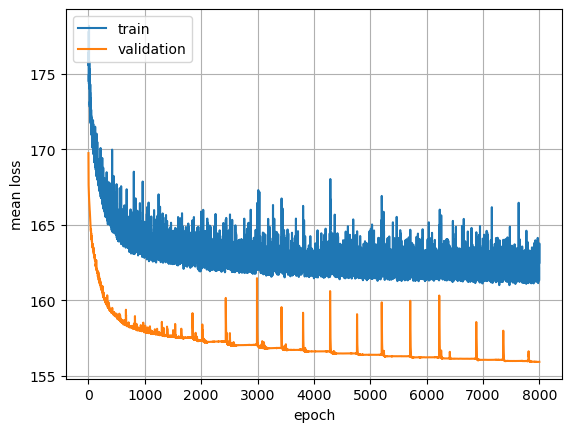

In [5]:
from models import JB_MFTrans
model = JB_MFTrans.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### JB_MF2 @8000 epoch

train loss at epoch 7999 = 161.13888549804688
train mean f1 score at epoch 7999 = 0.9670547842979431
validation loss at epoch 7999 = 154.97258758544922
validation mean f1 score at epoch 7999 = 0.9386192560195923
MSE loss : 0.03039604239165783
Accuracy : 0.9695543646812439
precision: 0.9401440024375916
Sensititvity :0.9593794941902161
specificity : 0.9739018082618713
f-score : 0.9496643543243408
MCC : 0.9279428720474243
AUROC: 0.9523946642875671
AUROC (metrics): 0.9683070284452091
AUPRC: 0.9039506912231445
AUPRC (metrics): 0.9177451692166144


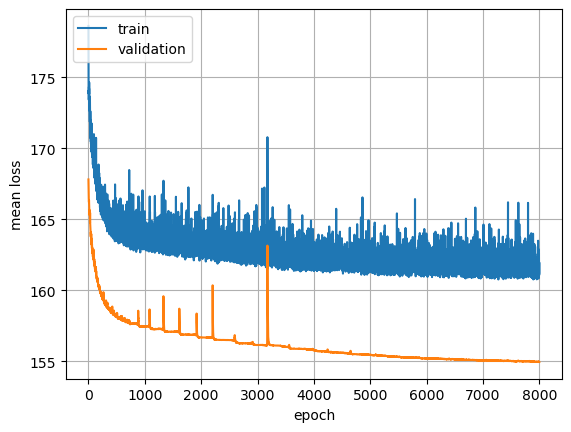

In [16]:
from models import JB_MF2
model = JB_MF2.JB_MF2(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### JB_MFGIN

train loss at epoch 7999 = 161.43095906575522
train mean f1 score at epoch 7999 = 0.9668136835098267
validation loss at epoch 7999 = 154.950927734375
validation mean f1 score at epoch 7999 = 0.9415894746780396
MSE loss : 0.028684666380286217
Accuracy : 0.9709681272506714
precision: 0.9434548616409302
Sensititvity :0.9605939388275146
specificity : 0.9754008054733276
f-score : 0.9519472718238831
MCC : 0.9312282800674438
AUROC: 0.9595073461532593
AUROC (metrics): 0.9745528034815537
AUPRC: 0.9267286658287048
AUPRC (metrics): 0.9363504001771987


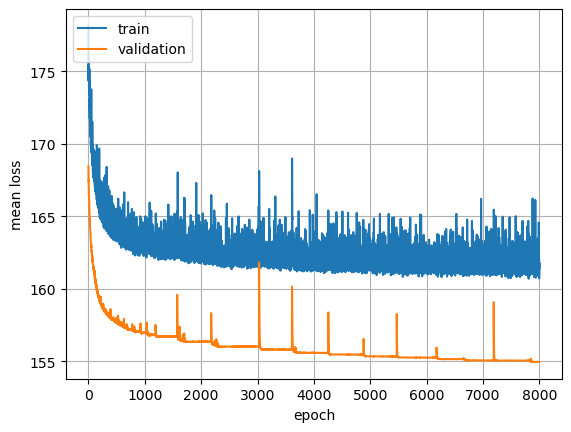

In [28]:
from models import JB_MFGIN
model = JB_MFGIN.MFGIN(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### MFGIN + linear

In [7]:
import torch
import torch.nn as nn
from torch_geometric.nn import MFConv, GINConv, ClusterGCNConv

class MF3(nn.Module):
    def __init__(self, in_channels=3, out_channels=6):
        super(MF3, self).__init__()
        self.conv1 = MFConv(in_channels, 4*in_channels, alpha=0.95)
        self.seq1 = nn.Sequential(nn.BatchNorm1d(4 * in_channels),
                          nn.ReLU(),
                          nn.Linear(4 * in_channels, 4 * in_channels),
                          nn.ReLU())
        
        self.conv2 = GINConv(
            nn.Sequential(nn.Linear(4 * in_channels, 8 * in_channels),
                          nn.BatchNorm1d(8 * in_channels),
                          nn.ReLU(),
                          nn.Linear(8 * in_channels, 8 * in_channels),
                          nn.ReLU())
        )
        self.conv3 = GINConv(
            nn.Sequential(nn.Linear(4 * in_channels, 8 * in_channels),
                          nn.BatchNorm1d(8 * in_channels),
                          nn.ReLU(),
                          nn.Linear(8 * in_channels, 8 * in_channels),
                          nn.ReLU())
        )

        self.linear2 = nn.Linear(16*in_channels, 8*in_channels)
        
        self.conv4 = ClusterGCNConv(8 * in_channels, 8 * in_channels, alpha=0.95)
        self.seq4 = nn.Sequential(nn.BatchNorm1d(8 * in_channels),
                          nn.ReLU(),
                          nn.Linear(8 * in_channels, 8 * in_channels),
                          nn.ReLU())
        
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        #self.linear1 = nn.Linear(32*in_channels, 16*in_channels)
        self.linear3 = nn.Linear(8*in_channels, 4*in_channels)
        self.out = nn.Linear(4*in_channels, out_channels)
        
    def forward(self, batch):
        x, edge_index, batch_graph = batch.x, batch.edge_index, batch.batch
        x = self.seq1(self.conv1(x, edge_index))
        x1 = self.conv2(x, edge_index)
        x2 = self.conv3(x, edge_index)
        x = torch.cat((x1, x2), dim = 1)
        x = self.linear2(x)
        x = self.seq4(self.conv4(x, edge_index))
        x = self.dropout(x)
        #x = self.linear1(x)
        x = self.linear3(x)
        x = self.out(x)
        x = self.sigmoid(x)
        return x


train loss at epoch 999 = 163.0802001953125
train mean f1 score at epoch 999 = 0.9130398631095886
validation loss at epoch 999 = 156.98300170898438
validation mean f1 score at epoch 999 = 0.8668708801269531
MSE loss : 0.07064676284790039
Accuracy : 0.9274929761886597
precision: 0.8614209890365601
Sensititvity :0.9030765295028687
specificity : 0.9379254579544067
f-score : 0.8817570805549622
MCC : 0.8299962282180786
AUROC: 0.9024012088775635
AUROC (metrics): 0.9362269744925436
AUPRC: 0.8340820670127869
AUPRC (metrics): 0.8494356086840866


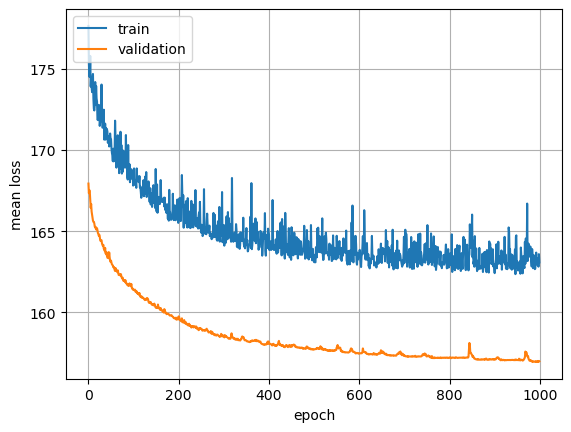

In [8]:
model = MF3(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### JB_MFTrans lr1e-2

train loss at epoch 999 = 176.6676279703776
train mean f1 score at epoch 999 = 0.48907753825187683
validation loss at epoch 999 = 168.98310089111328
validation mean f1 score at epoch 999 = 0.4796563982963562
MSE loss : 0.33395370841026306
Accuracy : 0.6660462617874146
precision: 0.45017412304878235
Sensititvity :0.5219694375991821
specificity : 0.7276065945625305
f-score : 0.4834206700325012
MCC : 0.24010226130485535
AUROC: 0.4999999701976776
AUROC (metrics): 0.6247880362643181
AUPRC: 0.2993638515472412
AUPRC (metrics): 0.3780822143367907


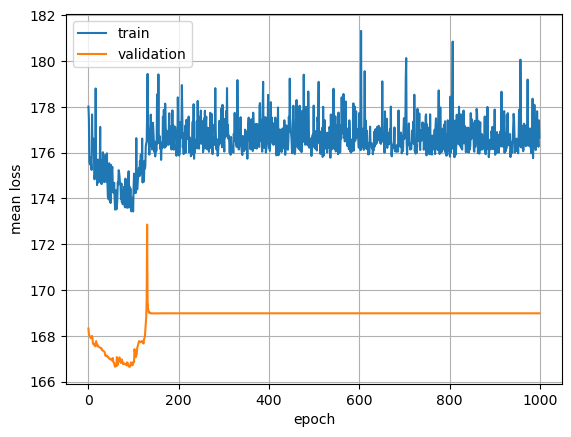

In [5]:
from models import GNN_Jennie_MFTrans
lr=1e-2
model = GNN_Jennie_MFTrans.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### JB_MFTrans lr 1e-4

train loss at epoch 999 = 168.82537841796875
train mean f1 score at epoch 999 = 0.7085037231445312
validation loss at epoch 999 = 162.41590118408203
validation mean f1 score at epoch 999 = 0.6713469624519348
MSE loss : 0.1894233375787735
Accuracy : 0.7907134294509888
precision: 0.6261767148971558
Sensititvity :0.746626615524292
specificity : 0.8095505237579346
f-score : 0.6811175346374512
MCC : 0.5316592454910278
AUROC: 0.7271991968154907
AUROC (metrics): 0.8166415774527667
AUPRC: 0.5458323359489441
AUPRC (metrics): 0.6530873588742037


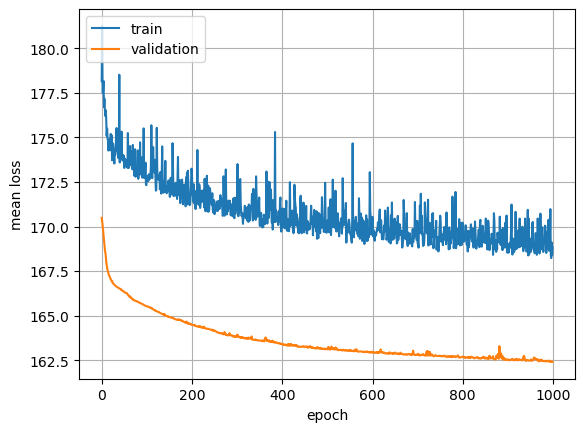

In [6]:
from models import GNN_Jennie_MFTrans
lr=1e-4
model = GNN_Jennie_MFTrans.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### lr1e-4 2000 epoch

train loss at epoch 1999 = 167.64823404947916
train mean f1 score at epoch 1999 = 0.7329891920089722
validation loss at epoch 1999 = 161.7889404296875
validation mean f1 score at epoch 1999 = 0.6930001974105835
MSE loss : 0.1768462359905243
Accuracy : 0.8089314103126526
precision: 0.6562223434448242
Sensititvity :0.7597802877426147
specificity : 0.829932451248169
f-score : 0.7042145133018494
MCC : 0.56751948595047
AUROC: 0.7456879019737244
AUROC (metrics): 0.8303299004772167
AUPRC: 0.571315586566925
AUPRC (metrics): 0.6661169625279328


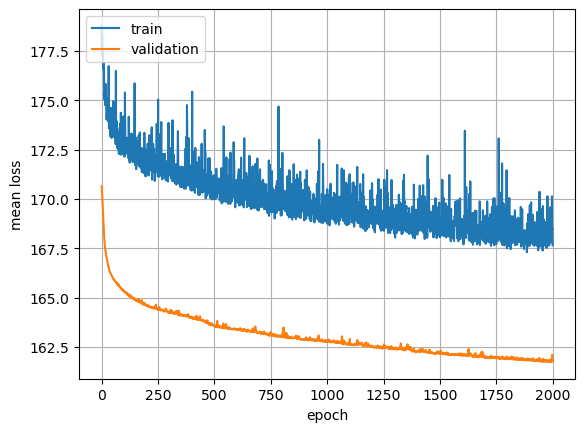

In [7]:
from models import GNN_Jennie_MFTrans
model = GNN_Jennie_MFTrans.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

## Cluster

### JB_Cluster

train loss at epoch 999 = 165.79896036783853
train mean f1 score at epoch 999 = 0.7938686609268188
validation loss at epoch 999 = 159.5748291015625
validation mean f1 score at epoch 999 = 0.7652314901351929
MSE loss : 0.139521524310112
Accuracy : 0.8564431071281433
precision: 0.7234691977500916
Sensititvity :0.8424805998802185
specificity : 0.8624089360237122
f-score : 0.7784525156021118
MCC : 0.6774492263793945
AUROC: 0.8044708371162415
AUROC (metrics): 0.8687114423868108
AUPRC: 0.6498159170150757
AUPRC (metrics): 0.7027722475498495


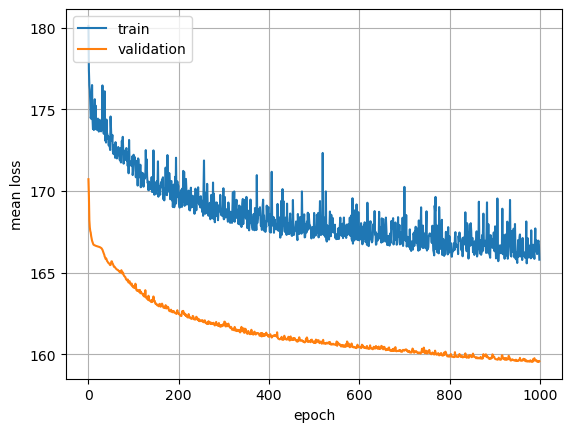

In [7]:
from models import JB_Cluster
model = JB_Cluster.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### JB_Cluster @ 8000

train loss at epoch 7999 = 163.6410369873047
train mean f1 score at epoch 7999 = 0.8972100615501404
validation loss at epoch 7999 = 157.1272430419922
validation mean f1 score at epoch 7999 = 0.8654252290725708
MSE loss : 0.07330553233623505
Accuracy : 0.9260911345481873
precision: 0.8646617531776428
Sensititvity :0.8928664326667786
specificity : 0.940287172794342
f-score : 0.8785377740859985
MCC : 0.8256627917289734
AUROC: 0.886109471321106
AUROC (metrics): 0.9205433406931318
AUPRC: 0.7936832308769226
AUPRC (metrics): 0.826105630414534


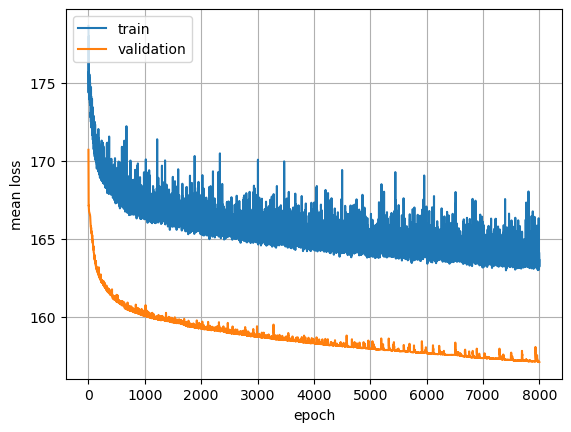

In [2]:
num_epochs=8000
from models import JB_Cluster
model = JB_Cluster.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### JB_ClusterMF

train loss at epoch 999 = 164.9017588297526
train mean f1 score at epoch 999 = 0.8444027900695801
validation loss at epoch 999 = 158.59424591064453
validation mean f1 score at epoch 999 = 0.803851842880249
MSE loss : 0.10966407507658005
Accuracy : 0.8870428800582886
precision: 0.7813887596130371
Sensititvity :0.8645550012588501
specificity : 0.8966513276100159
f-score : 0.8208707571029663
MCC : 0.7407070398330688
AUROC: 0.8492214679718018
AUROC (metrics): 0.8984748194106236
AUPRC: 0.7276535630226135
AUPRC (metrics): 0.7648533715669683


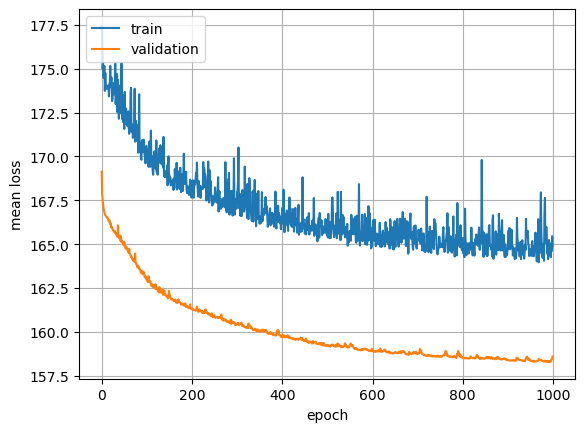

In [6]:
from models import JB_ClusterMF
model = JB_ClusterMF.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### JB_ClusterMF @ 8000

train loss at epoch 7999 = 162.68924967447916
train mean f1 score at epoch 7999 = 0.940595269203186
validation loss at epoch 7999 = 156.0498046875
validation mean f1 score at epoch 7999 = 0.9064298868179321
MSE loss : 0.04774206876754761
Accuracy : 0.9519273042678833
precision: 0.914865255355835
Sensititvity :0.9255457520484924
specificity : 0.9631994366645813
f-score : 0.9201744794845581
MCC : 0.8858146071434021
AUROC: 0.9197944402694702
AUROC (metrics): 0.9490350895876802
AUPRC: 0.8599858283996582
AUPRC (metrics): 0.8865395480637778


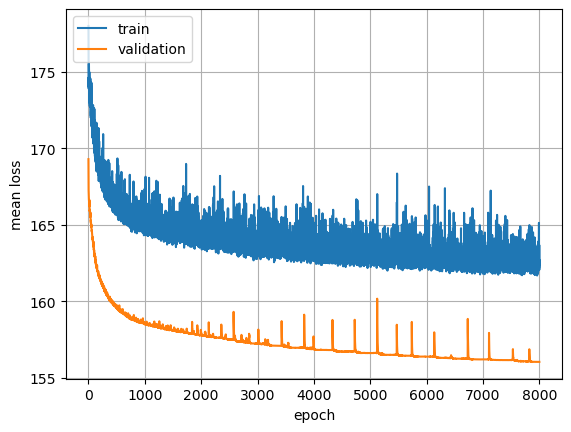

In [4]:
num_epochs=8000
from models import JB_ClusterMF
model = JB_ClusterMF.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### WW_ClusterCGN

train loss at epoch 999 = 169.4004160563151
train mean f1 score at epoch 999 = 0.7157990336418152
validation loss at epoch 999 = 161.56816864013672
validation mean f1 score at epoch 999 = 0.6936959028244019
MSE loss : 0.1818659007549286
Accuracy : 0.8027839660644531
precision: 0.6359462141990662
Sensititvity :0.7980918884277344
specificity : 0.8047887086868286
f-score : 0.7078522443771362
MCC : 0.5701143145561218
AUROC: 0.7638004422187805
AUROC (metrics): 0.8425727454741367
AUPRC: 0.5703872442245483
AUPRC (metrics): 0.6568676870454958


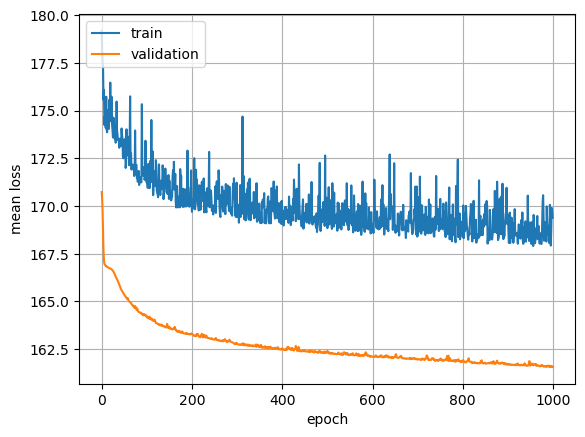

In [2]:
from models import WW_ClusterGCN
model = WW_ClusterGCN.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### WW_ClusterCGN @ 8000

train loss at epoch 7999 = 167.63587951660156
train mean f1 score at epoch 7999 = 0.7690421342849731
validation loss at epoch 7999 = 160.35614776611328
validation mean f1 score at epoch 7999 = 0.7324298620223999
MSE loss : 0.15947793424129486
Accuracy : 0.835951030254364
precision: 0.6888859272003174
Sensititvity :0.824259340763092
specificity : 0.8409465551376343
f-score : 0.7505170702934265
MCC : 0.6353917717933655
AUROC: 0.8003167510032654
AUROC (metrics): 0.8597060044548108
AUPRC: 0.6329332590103149
AUPRC (metrics): 0.6740921903327785


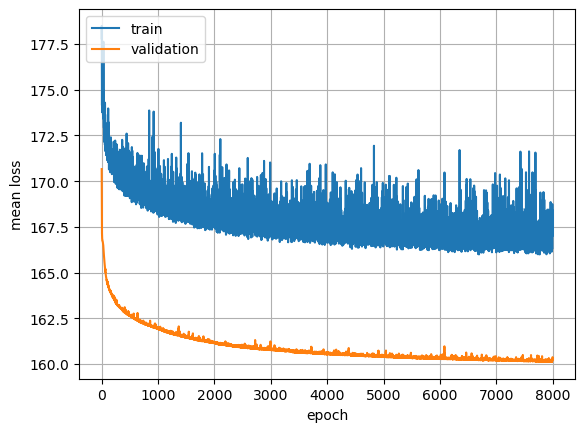

In [5]:
num_epochs=8000
from models import WW_ClusterGCN
model = WW_ClusterGCN.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

## GIN

### WW_GIN

train loss at epoch 999 = 163.4550577799479
train mean f1 score at epoch 999 = 0.8948301672935486
validation loss at epoch 999 = 157.3182373046875
validation mean f1 score at epoch 999 = 0.8581258058547974
MSE loss : 0.07786986976861954
Accuracy : 0.9204866886138916
precision: 0.8487939834594727
Sensititvity :0.8935760855674744
specificity : 0.9319849610328674
f-score : 0.8706095218658447
MCC : 0.8138337731361389
AUROC: 0.8909620046615601
AUROC (metrics): 0.9262957467892456
AUPRC: 0.8114584684371948
AUPRC (metrics): 0.8367024545984842


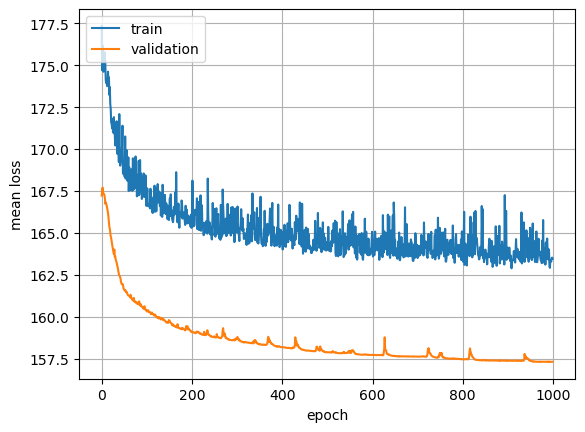

In [3]:
from models import WW_GIN
model = WW_GIN.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### WWGIN @8000 epoch

train loss at epoch 7999 = 161.35265096028647
train mean f1 score at epoch 7999 = 0.9617452621459961
validation loss at epoch 7999 = 154.89502716064453
validation mean f1 score at epoch 7999 = 0.9315739274024963
MSE loss : 0.03217385709285736
Accuracy : 0.9668374061584473
precision: 0.9217429757118225
Sensititvity :0.9717235565185547
specificity : 0.9647496938705444
f-score : 0.9460736513137817
MCC : 0.9228245615959167
AUROC: 0.9630180597305298
AUROC (metrics): 0.9754453492934015
AUPRC: 0.9177916646003723
AUPRC (metrics): 0.9228967154697599


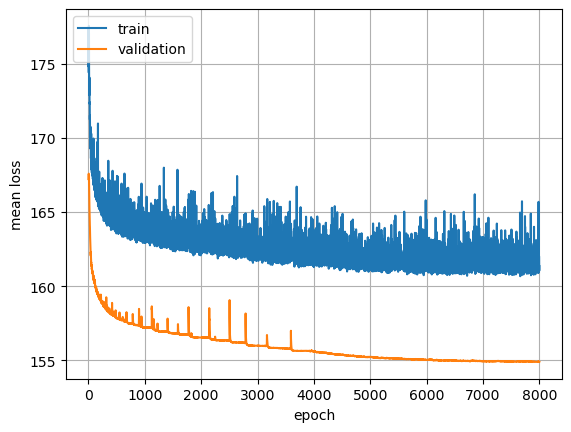

In [3]:
num_epochs=8000
from models import WW_GIN
model = WW_GIN.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### JB_GIN

## GCNII

### JB_GCNII

train loss at epoch 0 = 177.73756408691406
train mean f1 score at epoch 0 = 0.468801349401474
validation loss at epoch 0 = 167.50416564941406
validation mean f1 score at epoch 0 = 0.5173866748809814
train loss at epoch 1 = 175.37720743815103
train mean f1 score at epoch 1 = 0.5278139114379883
validation loss at epoch 1 = 168.09061431884766
validation mean f1 score at epoch 1 = 0.5168142914772034
train loss at epoch 2 = 175.51402282714844
train mean f1 score at epoch 2 = 0.5308675765991211
validation loss at epoch 2 = 167.36710357666016
validation mean f1 score at epoch 2 = 0.5204373598098755
train loss at epoch 3 = 174.1945597330729
train mean f1 score at epoch 3 = 0.5315254926681519
validation loss at epoch 3 = 166.89077758789062
validation mean f1 score at epoch 3 = 0.5231873393058777
train loss at epoch 4 = 173.80402628580728
train mean f1 score at epoch 4 = 0.5327847599983215
validation loss at epoch 4 = 166.51223754882812
validation mean f1 score at epoch 4 = 0.5250067710876465
tr

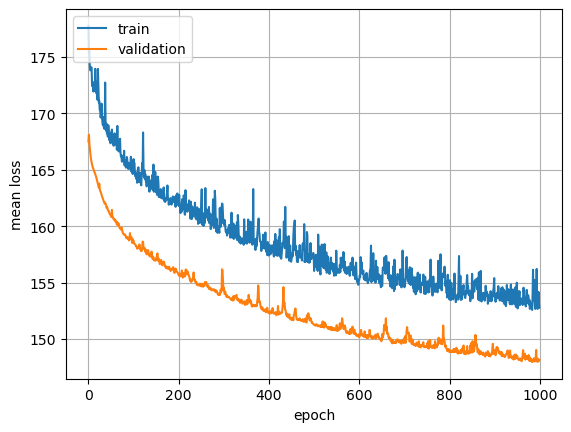

In [2]:
from models import JB_GCNII

model = JB_GCNII.GCNConvNet(in_channels=in_channels, nlayers=9, nhidden=1000, out_channels=out_channels, dropout=0.2, alpha=0.5)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=True)
#test(model, test_loader, in_channels, out_channels, num_epochs, lr)

train loss at epoch 0 = 177.73756408691406
train mean f1 score at epoch 0 = 0.468801349401474
validation loss at epoch 0 = 167.50416564941406
validation mean f1 score at epoch 0 = 0.5173866748809814
train loss at epoch 1 = 175.37720743815103
train mean f1 score at epoch 1 = 0.5278139114379883
validation loss at epoch 1 = 168.09061431884766
validation mean f1 score at epoch 1 = 0.5168142914772034
train loss at epoch 2 = 175.51402282714844
train mean f1 score at epoch 2 = 0.5308675765991211
validation loss at epoch 2 = 167.36710357666016
validation mean f1 score at epoch 2 = 0.5204373598098755
train loss at epoch 3 = 174.1945597330729
train mean f1 score at epoch 3 = 0.5315254926681519
validation loss at epoch 3 = 166.89077758789062
validation mean f1 score at epoch 3 = 0.5231873393058777
train loss at epoch 4 = 173.80402628580728
train mean f1 score at epoch 4 = 0.5327847599983215
validation loss at epoch 4 = 166.51223754882812
validation mean f1 score at epoch 4 = 0.5250067710876465
tr

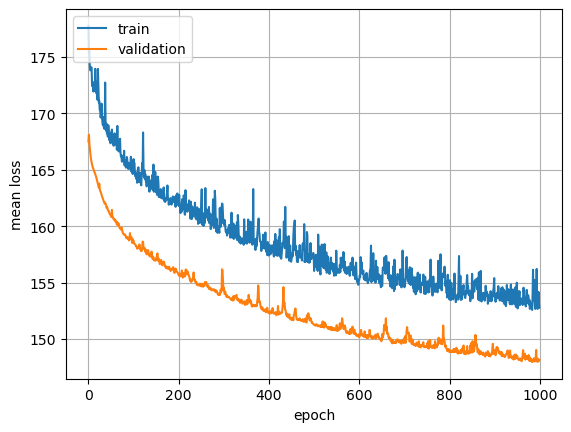

In [2]:
from models import JB_GCNII

model = JB_GCNII.GCNConvNet(in_channels=in_channels, nlayers=9, nhidden=1000, out_channels=out_channels, dropout=0.2, alpha=0.5)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=True)
#test(model, test_loader, in_channels, out_channels, num_epochs, lr)

## SAGE

### JB_SAGE

train loss at epoch 999 = 168.67687479654947
train mean f1 score at epoch 999 = 0.7606824636459351
validation loss at epoch 999 = 160.6331024169922
validation mean f1 score at epoch 999 = 0.7308735847473145
MSE loss : 0.1612413227558136
Accuracy : 0.83510422706604
precision: 0.6952897906303406
Sensititvity :0.799606204032898
specificity : 0.8502716422080994
f-score : 0.7438083291053772
MCC : 0.6264162659645081
AUROC: 0.7545718550682068
AUROC (metrics): 0.8370601077099638
AUPRC: 0.589006245136261
AUPRC (metrics): 0.6568700743021585


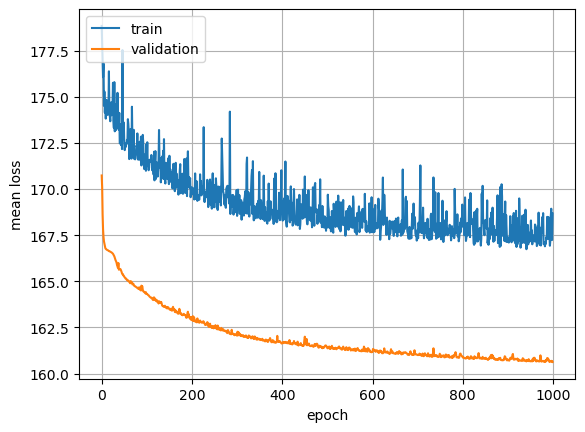

In [4]:
from models import JB_SAGE
model = JB_SAGE.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### YL_Sage @ 8000 epoch

In [6]:
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv

class GSage(nn.Module):

    def __init__(self, in_channels=3, out_channels=6):
        super(GSage, self).__init__()

        self.conv1 = SAGEConv(in_channels, out_channels=128, aggr="max")
        self.conv2 = SAGEConv(in_channels=128, out_channels=128, aggr="max")
        self.conv3 = SAGEConv(in_channels=128, out_channels=128, aggr="max")
        self.dropout = nn.Dropout(0.25)
        self.lin1 = torch.nn.Linear(128, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, out_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, batch):

        x, edge_index, batch = batch.x, batch.edge_index, batch.batch

        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)

        x = torch.relu(self.lin1(x))
        x = self.dropout(x)
        x = torch.relu(self.lin2(x))
        x = self.lin3(x)
        x = self.sigmoid(x)
        return x

C:\Users\lenni\miniconda3\envs\gnn4chem\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


train loss at epoch 7999 = 163.65001424153647
train mean f1 score at epoch 7999 = 0.8635863661766052
validation loss at epoch 7999 = 158.5243377685547
validation mean f1 score at epoch 7999 = 0.8074071407318115
MSE loss : 0.10633693635463715
Accuracy : 0.8915281891822815
precision: 0.7905347943305969
Sensititvity :0.8675236105918884
specificity : 0.9017847180366516
f-score : 0.8272417783737183
MCC : 0.7501524686813354
AUROC: 0.8524209856987
AUROC (metrics): 0.9023096855163305
AUPRC: 0.7469708919525146
AUPRC (metrics): 0.7765281529485721


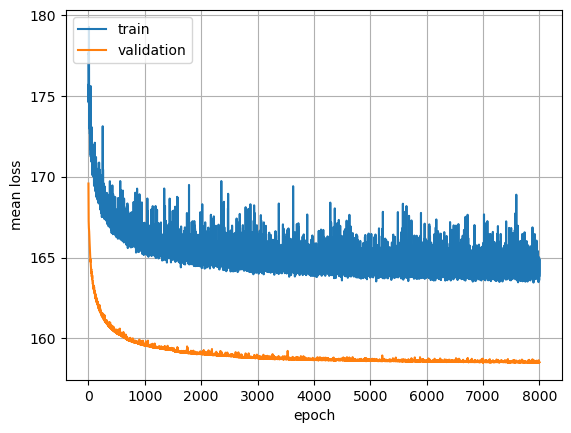

In [8]:
model = GSage(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

## GAT

### JB_GAT

train loss at epoch 999 = 172.1394500732422
train mean f1 score at epoch 999 = 0.7470173835754395
validation loss at epoch 999 = 160.91497039794922
validation mean f1 score at epoch 999 = 0.7136180400848389
MSE loss : 0.16199445724487305
Accuracy : 0.821179986000061
precision: 0.6628111600875854
Sensititvity :0.8196365833282471
specificity : 0.821839451789856
f-score : 0.7329287528991699
MCC : 0.6084262728691101
AUROC: 0.8042598962783813
AUROC (metrics): 0.8658799340069682
AUPRC: 0.6396328806877136
AUPRC (metrics): 0.6936481660435865


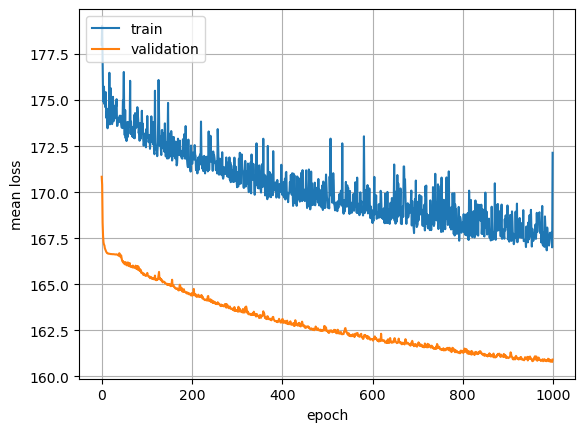

In [5]:
from models import JB_GAT
model = JB_GAT.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)

### IR_GAT @8000 epoch

train loss at epoch 7999 = 166.10106404622397
train mean f1 score at epoch 7999 = 0.7698633670806885
validation loss at epoch 7999 = 160.1633529663086
validation mean f1 score at epoch 7999 = 0.7405215501785278
MSE loss : 0.152997687458992
Accuracy : 0.8423752784729004
precision: 0.6967016458511353
Sensititvity :0.8384925127029419
specificity : 0.8440342545509338
f-score : 0.761049211025238
MCC : 0.6511006355285645
AUROC: 0.8102912306785583
AUROC (metrics): 0.8664116961033811
AUPRC: 0.6462812423706055
AUPRC (metrics): 0.6874149885798095


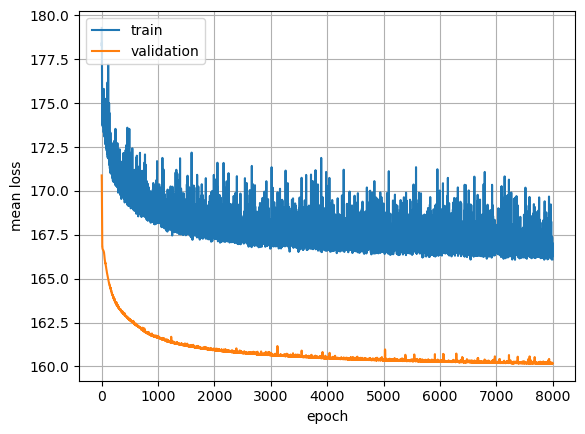

In [4]:
from models import GNN_GAT
model = GNN_GAT.GCNConvNet(in_channels=in_channels, out_channels=out_channels)
model = train(model, train_loader, num_epochs, in_channels, out_channels, lr, val_loader, debug=debug)
test(model, test_loader, in_channels, out_channels, num_epochs, lr)